<a href="https://colab.research.google.com/github/okitouni/MoDe/blob/master/ExampleWtagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Various imports.**

In [1]:
from time import time
import numpy as np
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib import rcParams
!wget https://raw.githubusercontent.com/okitouni/MoDe/master/mode_torch.py
!wget https://raw.githubusercontent.com/okitouni/PaperMPLstyle/main/paper.mplstyle
from mode_torch import MoDeLoss
plt.style.use("./paper.mplstyle")
rcParams['font.family'] = 'sans-serif'

--2020-11-01 03:19:23--  https://raw.githubusercontent.com/okitouni/MoDe/master/mode_torch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘mode_torch.py’

mode_torch.py       100%[===================>]  14.71K  --.-KB/s    in 0.001s  

2020-11-01 03:19:23 (10.0 MB/s) - ‘mode_torch.py’ saved [15061/15061]

--2020-11-01 03:19:23--  https://raw.githubusercontent.com/okitouni/PaperMPLstyle/main/paper.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1698 (1.7K) [text/plain]
Saving to: ‘paper.mplsty

**First we will download the W-tagging data.**

W_high_level.npz: train|test|val for the W tagging task using high level variables.

Each train|test|val array has the shape (N,12) where N is the number of examples.

Test: N=850000
Train: N=360000
Val: N=410000

The 12 columns are (in this order):

'mass', 'pt', 'tau21',  'c2',  'd2', 'fw',  'pf', 'ap', 'zcutdef', 'ktdr', 'sqrtd12', 'label'

For definitions of the variables 1-11 see  [[MoDe-PAPER]](https://arxiv.org/pdf/2010.09745.pdf), [DISCO-PAPER], or ATL-PHYS-PUB-2018-014.

Mass is: (Mass_in_GeV - 50)/250

The final column (label) is 0 for W Jets and 1 for QCD

In [2]:
!wget https://zenodo.org/record/3606767/files/W_high_level.npz

--2020-11-01 03:20:56--  https://zenodo.org/record/3606767/files/W_high_level.npz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155520682 (148M) [application/octet-stream]
Saving to: ‘W_high_level.npz’

W_high_level.npz    100%[===================>] 148.32M  16.8MB/s    in 8.0s    

2020-11-01 03:21:05 (18.4 MB/s) - ‘W_high_level.npz’ saved [155520682/155520682]



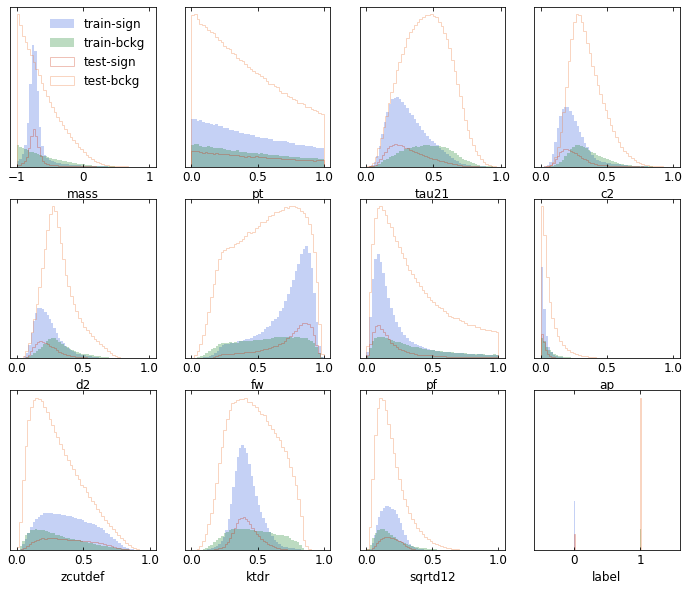

In [3]:
#dataset 
files = np.load("W_high_level.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')
test = files["test"].astype('float32')

train_labels = train[::,-1]
val_labels   = val[::,-1]
test_labels=test[::,-1]

data = np.concatenate([train,val,test],axis=0)
maxdata = data.max(axis=0)
mindata = data.min(axis=0)
data = (data-mindata)/(maxdata-mindata)
data[::,0] = 2*(data[::,0]-data[:,0].min())/(data[:,0].max()-data[:,0].min())-1
# data[:,:-1] = (data[:,:-1] - data[:,:-1].mean(axis=0))/np.std(data[:,:-1],axis=0)

train = data[:train.shape[0]]
val = data[train.shape[0]:val.shape[0]+train.shape[0]]
test = data[val.shape[0]+train.shape[0]:]


fig, axes = plt.subplots(3,4,figsize=(12,10))
histtype='bar'
label = ['mass', 'pt', 'tau21', 'c2', 'd2', 'fw', 'pf', 'ap',
         'zcutdef', 'ktdr', 'sqrtd12', 'label']
for i,ax in enumerate(axes.flatten()):
    if i==11:histtype='bar'
    ax.hist(train[:,i][train[:,-1]==0],bins=50,alpha=0.3,label='train-sign',
            histtype=histtype)
    ax.hist(train[:,i][train[:,-1]==1],bins=50,alpha=0.3,label='train-bckg',
            histtype=histtype)
    ax.hist(test[:,i][test[:,-1]==0],bins=50,alpha=0.3,label='test-sign',
            histtype='step')
    ax.hist(test[:,i][test[:,-1]==1],bins=50,alpha=0.3,label='test-bckg',
            histtype='step')
    ax.set_yticks([])
    if i==0: ax.legend()
    ax.set_xlabel(label[i])

test_mass = files["test"].astype('float32')[:,0]*250+50

In [4]:
from torch.utils.data import Dataset
class Dataset(Dataset):
    def __init__(self, samples,labels,m=None,weights=None):
        'Initialization'
        self.labels = labels
        self.samples = samples
        self.m = m
        if len(samples)!=len(labels):
            raise ValueError(f"should have the same number of samples\
            ({len(samples)}) as there are labels({len(labels)})")
        if weights is None:
            self.weights = np.ones_like(labels)
        else:
            if len(weights)!=len(labels):
                raise ValueError(f"should have the same number of weights\
                ({len(weights)}) as there are samples({len(labels)})")
            self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Select sample
        X = self.samples[index]
        y = self.labels[index]
        m = self.m[index] if self.m is not None else self.m
        w = self.weights[index]
        return  X,y,m,w
""" Finalize dataset """
traindataset = Dataset(samples=train[::,1:-1],
                       labels=train_labels,
                       m = train[::,0])
valdataset = Dataset(samples=val[:,1:-1],
                     labels=val_labels,
                    m = val[::,0])
X = torch.from_numpy(test[:,1:11]).float()

Here we will define various helper functions used for plotting and computing the metrics *R50* and *1/JSD* as described in the MoDe paper (see above.)

In [5]:
from scipy.stats import entropy
class Metrics():
    def __init__(self,validation=False):
        self.validation = validation
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
        if self.validation:
            self.R50 = []
            self.JSD = []
    def calculate(self,pred,target,l=None,m=None):
        preds = np.array(pred.tolist()).flatten()
        targets = np.array(target.tolist()).flatten()
        acc = (preds.round()==targets).sum()/targets.shape[0]
        signal_efficiency = ((preds.round()==targets)&(targets==0)).sum()/(targets==1).sum()
        background_efficiency = ((preds.round()==targets)&(targets==1)).sum()/(targets==0).sum()
        if self.validation:
            c = find_threshold(preds,(targets==0),0.5)
            R50 = 1/((preds[targets==1]<c).sum()/(targets==1).sum())
            self.R50.append(R50)
            if m is not None:
                m = np.array(m.tolist()).flatten()
                hist1, bins = np.histogram(m[(targets==1)&(preds>c)],bins=50,density=True)
                hist2, _ = np.histogram(m[(targets==1)&(preds<c)],bins=bins,density=True)
                JSD = 0.5*(entropy(hist1,0.5*(hist1+hist2))+entropy(hist2,0.5*(hist1+hist2)))
                self.JSD.append(JSD)
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
def metric_calc(model,X,y,x_biased,metric=None):
    predictions = np.array(model(X).tolist()).flatten()
    if metric is None:
        metrics_test = Metrics(validation=True) 
    else:
        metrics_test = metric(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    return (1/JSD,R50)
def find_threshold(L,mask,x_frac):
    """
    Calculate c such that x_frac of the array is less than c.

    Parameters
    ----------
    L : Array
        The array where the cutoff is to be found
    mask : Array,
        Mask that returns L[mask] the part of the original array over which it is desired to calculate the threshold.
    x_frac : float
        Of the area that is lass than or equal to c.

    returns c (type=L.dtype)
    """
    max_x = mask.sum()
    x = int(np.round(x_frac * max_x))
    L_sorted = np.sort(L[mask.astype(bool)])
    return L_sorted[x]   
def plot_stuff(predictions,y,x_biased,mbins=100,histbins=None,name='Naive DNN',f=None,ptype=0,dynamicbins=True,scale=None,xlim=None,legend_ncol=3):
    if histbins == None:
        histbins=mbins
    predictions = np.array(predictions).flatten()
    metrics_test = Metrics(validation=True) 
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    
    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=histbins,alpha=0.3,color='C1',label='Background',density=True,log=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True,log=True)
    ax.set_ylabel("Normed Counts",fontsize=14)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)[::-1]
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m = x_biased[y==1]
    scores = predictions[y==1]
    if dynamicbins:
        mod = len(m)%mbins
        if mod!=0:
            m = m[:-mod]
            scores = scores[:-mod]
        sorted_m = np.argsort(m)
        scores = scores[sorted_m].reshape(mbins,-1)
        m = m[sorted_m]
        m = m.reshape(mbins,-1).mean(axis=1)
    else:
        _,bins = np.histogram(m,bins=mbins)
        digitized = np.digitize(m,bins)
        m = (bins[:-1] + bins[1:])*0.5
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        if dynamicbins:
            passed = (scores<cut).sum(axis=1)/scores.shape[1]
        else:
            passed = [(scores[digitized==i+1]<cut).sum()/(digitized==i+1).sum() for i in range(mbins)]
        if ptype == 0:
            ax1.plot(m,passed,label="{:0.1f}".format(efficiencies[j]),alpha=0.9,c=c,lw=1)
        else:
            ax1.step(m,passed,label="{:0.1f}".format(efficiencies[j]),alpha=0.9,c=c,lw=1)
    if scale is not None:
        ax1.set_yscale(scale)        
    ax1.set_ylabel("False Pos. Rate",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    if xlim: ax1.set_xlim(xlim)
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="True Pos. Rate (Signal Efficiency)",ncol=legend_ncol)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    if f is not None:
        fig.savefig(f)
    plt.show()
    return (1/JSD,R50)
from os.path import exists
def swish(x):
    return x* torch.sigmoid(x)   

# Build a model
Here we will define our classifier. It is a simple NN with 3 fully connected layers (64) with swish activation. We will also define a `fit` method that includes our training loop.

In [6]:
class Model(torch.nn.Module):
    def __init__(self,input_size=10):
        """
         DNN Model inherits from torch.torch.nn.Module. Can be initialized with input_size: Number of features per sample.

        This is a class wrapper for a simple DNN model. Creates an instance of torch.torch.nn.Module that has 4 linear layers. Use torchsummary for details.abs

        Parameters
        ----------
        input_size : int=10
            The number of features to train on.
        name : string=None
            Specifiy a name for the Dtorch.nn.break
        """
        super().__init__()
        self.linear = torch.nn.Linear(input_size,64,bias=False)
        self.linear1 = torch.nn.Linear(64,64,)
        self.linear2 = torch.nn.Linear(64,64)
        self.batchnorm = torch.nn.BatchNorm1d(64)
        self.out = torch.nn.Linear(64,1)
    def forward(self, x):
        x = swish(self.linear(x))
        x = self.batchnorm(x)
        x = swish(self.linear1(x))
        x = swish(self.linear2(x))
        x = torch.sigmoid(self.out(x))
        return x 
    def fit(self,traindataset,epochs=200,batch_size=None, shuffle=False, num_workers=None, optimizer=None,scheduler=None,loss=None,interval=100,valdataset=None,drop_last=False,metrics=None,delay_loss=False,pass_x_biased=False,device='cpu',verbose=True):
        """
        Fit model to traindataset.

        Parameters
        ----------
        traindataset : DataSet
            The DataSet [torch.utils.data.Dataset] instance containing the training data. Used to create a DataLoader. Must return x,y,m where x is the vector of features, y is the label and m is the biased feature.
        epochs : int
            Number of epochs to train.
        batch_size : int
            Size of the batch.
        shuffle : bool
            If True shuffles the training data.
        num_workers : int
            Passed to DataLoader.
        optimizer : torch.optim
            Optimizer to use in the training. Defaults to torch.optim.SGD(lr-1e-3).
        scheduler : torch.optim.lr_scheduler
            Scheduler used to change the learning rate.
        loss : Callable
            Criterion to minimize. Defaults to torch.nn.MSELoss
        interval : int
            Log and print progress every epochs mod interval == 0.
        valdataset : DataSet
            Same as traindataset but for the validation data.
        drop_last : bool
            If drop_last the DataLoader will only keep floor(len(traindataset)/batch_size). Used if the loss requires batches of the same size.
        metrics : [Metrics,Metrics]
            Metrics object where to store the training/validation metrics.
        delay_loss : int
            Delay using the provided loss for delay_loss epochs. Optmizer uses WeightedMSE before that.
        pass_x_biased : bool
            If true, passes the biased feature as a third argument to the loss function.
        device : str or torch.device
            Which device to use. Defaults to cpu.
        """
        if optimizer is None:
            optimizer = torch.optim.Adam(self.parameters(),lr=1e-3)
        if loss:
            self.loss = loss
        if metrics is None:
            metrics = [Metrics(),Metrics(validation=True)]
        if valdataset:
            validation_generator = DataLoader(valdataset,batch_size=len(valdataset),shuffle=False)
        training_generator = DataLoader(traindataset, batch_size=batch_size, shuffle=shuffle,num_workers=num_workers,drop_last=drop_last)
        t0 = time()
        loss = 0
        acc = 0
        self.losses = []
        print("Entering Training...")
        for epoch in range(1,epochs+1):
           # Feed forward
            #self.loss.m = torch.Tensor().to(device)
            #self.loss.pred_long = torch.Tensor().to(device)
            for item in training_generator:
                x,y,m,weights = item
                if device!='cpu':
                    x,y,m,weights = x.to(device),y.to(device),m.to(device), weights.to(device)
                self.train()
                yhat = self(x).view(-1)
                if epoch<delay_loss:
                    l = torch.nn.MSELoss()(yhat,y)
                elif pass_x_biased==False:
                    l = self.loss(pred=yhat,target=y,weights=weights)
                else:
                    l = self.loss(pred=yhat,target=y,x_biased=m,weights=weights)
                l.backward()
                self.losses.append(l.item())  #delete later
                metrics[0].losses.append(l.item())
                optimizer.step()
                optimizer.zero_grad()
                if scheduler is not None: scheduler.step()
            #Validation and Printing
            if valdataset:
                if epoch % interval ==0 or epoch == epochs or epoch==1:
                    self.train(False)
                    for x,yval,m_val,weights in  validation_generator:
                        break
                    if device!='cpu':
                        x,yval,m_val = x.to(device),yval.to(device),m_val.to(device)
                   #     weights = weights.to(device)
                    yhat_val = self(x).view(-1)
                    valloss = lambda x,y: ((x-y)**2).mean()
                    l_val = valloss(yhat_val,yval)
                    metrics[0].calculate(pred=yhat.data,target=y,m=m)
                    metrics[1].calculate(pred=yhat_val.data,target=yval,m=m_val,l=l_val.item())
                    if verbose or log is not None:
                        acc = metrics[0].accs[-1]
                        R50 = metrics[1].R50[-1]
                        JSD = metrics[1].JSD[-1]
                        acc_val = metrics[1].accs[-1]
                        entry = 'Epoch:{:04d}/{:04d}  ({t:<5.1f}s)\n'.format(epoch,epochs,t=time()-t0) +\
                                ' Train: loss:{:.4f}, acc:{:.1f}%'.format(l.item(),100*acc) +\
                                ' || Val: loss: {:.4f}, acc:{:.1f}%, R50: {:.4f}, 1/JSD: {:.4f}'.format(
                    l_val.item(), 100.* acc_val,R50,1/JSD)
                        if verbose:
                            print(entry)
                    del x, yval, m, l_val, m_val, weights
                    self.yhat_val = yhat_val.data.cpu()
            else:
                if epoch % interval ==0:
                    metrics[0].calculate(pred=yhat.data,target=y,l=l.item())
                    acc = metrics[0].accs[-1]
                    entry = 'Epoch:{:04d}/{:04d} loss: {:.4f}, accuracy:({:.0f}%)'.format(
                        epoch,epochs,l.item(), 100.* acc)
                    print(entry)
        del l,y,item, yhat
        if valdataset: del yhat_val
        if device!="cpu": torch.cuda.empty_cache()

In [7]:
# Select training paramters
np.random.seed(42)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
params = {'epochs'       : 50,
          'interval'     : 10, # every "interval" print validation results
          'batch_size'   : 2**14,
          'shuffle'      : True,
          'num_workers'  : 6, # to load data in preparation of next iteration uses more memory but saves time.
          'drop_last'    : False,
          'device'       : device,
          'pass_x_biased': True,
         }
lr = 1e-2
print("Using device:", device)

Using device: cuda:0


In [8]:
#Train a standard classifier without MoDe loss (only classification loss)
torch.manual_seed(777)
model = Model(input_size=traindataset.samples.shape[1]).to(device)
# Instantiate MoDe Loss 
loss = lambda pred,target,x_biased,weights: torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset, valdataset=valdataset, 
          optimizer=optimizer,loss=loss)

Entering Training...
Epoch:0001/0050  (6.9  s)
 Train: loss:0.1371, acc:80.9% || Val: loss: 0.3857, acc:20.9%, R50: 14.1765, 1/JSD: 8.8353
Epoch:0010/0050  (33.0 s)
 Train: loss:0.1198, acc:83.3% || Val: loss: 0.1777, acc:74.8%, R50: 25.4492, 1/JSD: 3.8147
Epoch:0020/0050  (67.3 s)
 Train: loss:0.1167, acc:83.5% || Val: loss: 0.1835, acc:73.8%, R50: 27.1516, 1/JSD: 3.3992
Epoch:0030/0050  (105.5s)
 Train: loss:0.1178, acc:83.6% || Val: loss: 0.1782, acc:74.4%, R50: 27.1047, 1/JSD: 3.4620
Epoch:0040/0050  (139.5s)
 Train: loss:0.1155, acc:83.9% || Val: loss: 0.1987, acc:71.6%, R50: 26.4529, 1/JSD: 4.0071
Epoch:0050/0050  (168.4s)
 Train: loss:0.1125, acc:84.3% || Val: loss: 0.1890, acc:72.9%, R50: 27.1337, 1/JSD: 3.8003


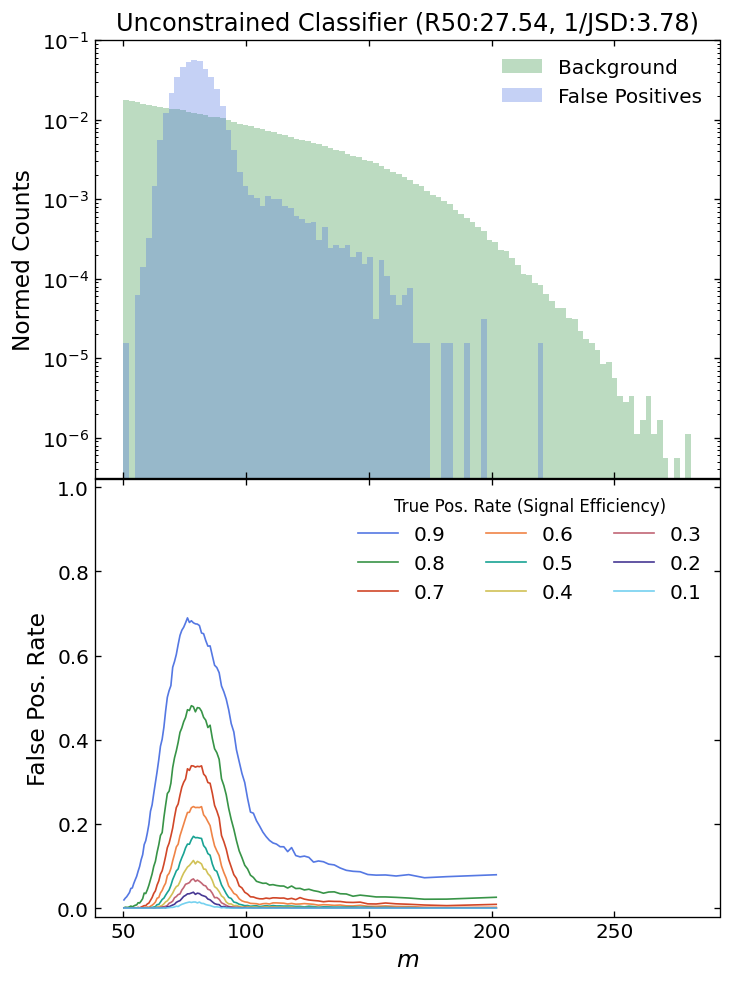

In [9]:
with torch.no_grad():
      title = r"Unconstrained Classifier"
      model.to("cpu")
      model.train(False)
      yhat_test = model(X).view(-1).tolist()
      plot_stuff(yhat_test,test_labels,test_mass,mbins=100,histbins=None,name=title,f=None,ptype=0,
                    dynamicbins=True,scale=None,xlim=None,legend_ncol=3)

In [10]:
#Train model with MoDe regularization (if everything works the shape of the 
# the acceptance rate (FPR) as a function of mass should be constrained.)
bins = 10   # MoDe mass bins
alpha = 300 # Relative strength of MoDe loss compared to classification loss
order = 0 # MoDe[order] highest Legendre mode to use
torch.manual_seed(777)
model = Model(input_size=traindataset.samples.shape[1]).to(device)
# Instantiate MoDe Loss 
MoDe = MoDeLoss(bins=bins,order=order,dynamicbins=True,background_label=1)
                                #max_slope=slope,eps=1e-5, monotonic=True)
loss = lambda pred,target,x_biased,weights: alpha * MoDe(pred,target,x_biased,) + torch.mean(weights*(target-pred)**2)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
model.fit(**params,traindataset=traindataset, valdataset=valdataset, 
          optimizer=optimizer,loss=loss)

Entering Training...
Epoch:0001/0050  (6.4  s)
 Train: loss:0.3347, acc:70.1% || Val: loss: 0.2666, acc:19.5%, R50: 3.9803, 1/JSD: 496.6647
Epoch:0010/0050  (34.5 s)
 Train: loss:0.2045, acc:69.0% || Val: loss: 0.3568, acc:19.5%, R50: 7.0768, 1/JSD: 686.2924
Epoch:0020/0050  (65.4 s)
 Train: loss:0.2183, acc:68.7% || Val: loss: 0.3627, acc:19.5%, R50: 7.4571, 1/JSD: 436.2778
Epoch:0030/0050  (96.2 s)
 Train: loss:0.2077, acc:69.3% || Val: loss: 0.3636, acc:19.5%, R50: 7.4811, 1/JSD: 564.7567
Epoch:0040/0050  (126.6s)
 Train: loss:0.2070, acc:69.7% || Val: loss: 0.3607, acc:19.5%, R50: 7.9766, 1/JSD: 1035.3592
Epoch:0050/0050  (166.9s)
 Train: loss:0.1996, acc:70.0% || Val: loss: 0.3565, acc:19.5%, R50: 7.8555, 1/JSD: 746.6259


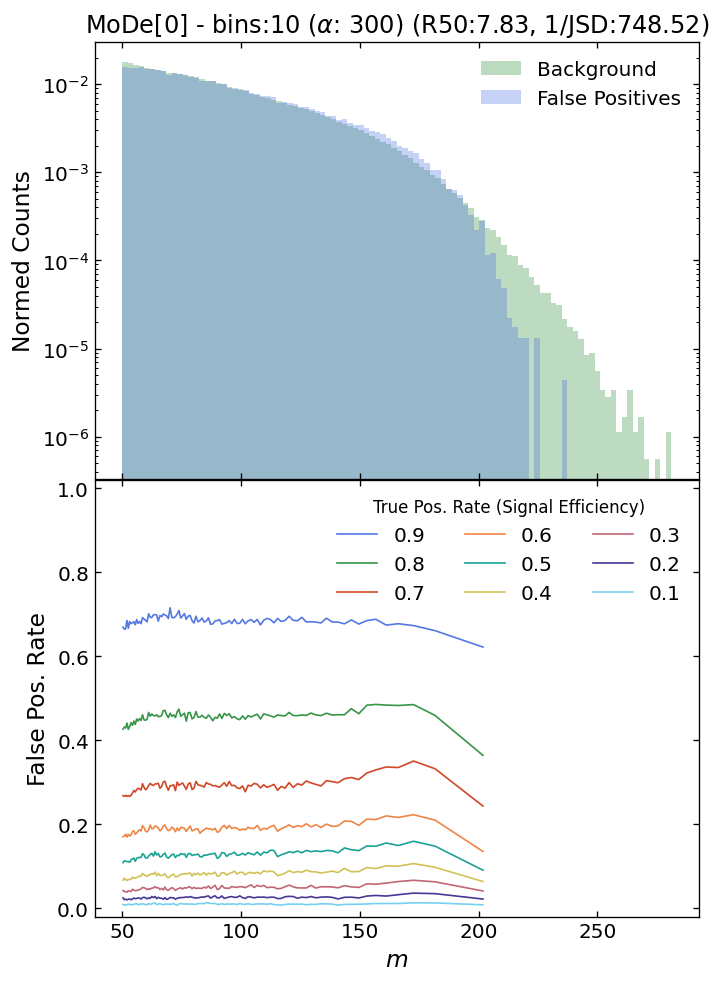

In [11]:
with torch.no_grad():
      title = r"MoDe[{:d}] - bins:{:d} ($\alpha$: {:d})"
      title = title.format(order,bins,alpha)
      model.to("cpu")
      model.train(False)
      yhat_test = model(X).view(-1).tolist()
      plot_stuff(yhat_test,test_labels,test_mass,mbins=100,histbins=None,name=title,f=None,ptype=0,
                    dynamicbins=True,scale=None,xlim=None,legend_ncol=3)